# Project 1: Exploratory Data Analysis of Movies
Amelia Dahm & Khyatee Desai

## Import Python Libraries

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
%matplotlib inline

## Read in CSV Files

In [4]:
movie_gross_raw = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
tmdb_raw = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
budgets_raw = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
characters_raw = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')

# Question 1: Which Movies Genres are Most Successful?


##  Read in Oscars Dataset
Source: https://www.kaggle.com/unanimad/the-oscar-award

In [5]:
oscars_raw = pd.read_csv('./zippedData/oscars.zip', encoding = "ISO-8859-1")
oscars_raw.head(3)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False


## Get the count of Oscar Nominations per movie

In [6]:
# subset the relevant data from Oscars df. Rename columns, drop rows with no movie title
oscars = oscars_raw.loc[:,['film','name', 'category']]
oscars.rename(columns={'film': 'title', 'name': 'person'}, inplace=True)
oscars.drop(oscars[oscars['title'].isnull()].index, inplace=True)


# create column for total number of oscar nominations per movie
counts = oscars['title'].value_counts()
d = counts.to_dict()
oscars['oscar_noms'] = oscars['title'].map(d)
oscars.head(3)

,title,person,category,oscar_noms
0,The Noose,Richard Barthelmess,ACTOR,1
1,The Last Command,Emil Jannings,ACTOR,2
2,A Ship Comes In,Louise Dresser,ACTRESS,1


## Unstack the Genre values
Genres were originally formatted as a comma-delimited string (ie 'Action, Crime, Drama'.) We reformatted this to give each genre its own row in the table.

In [7]:
# Unstacking Genre column to create individual rows (takes a while to run cell)
genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('primary_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['primary_title', 'genres']
genre_unstack.head(3)

,primary_title,genres
0,Sunghursh,Action
1,Sunghursh,Crime
2,Sunghursh,Drama


## Merge Oscars table with Genre table

In [8]:
oscar_genre = oscars.merge(genre_unstack, how = 'left', left_on='title', right_on='primary_title').drop('primary_title', axis=1)
oscar_genre.head(3)

,title,person,category,oscar_noms,genres
0,The Noose,Richard Barthelmess,ACTOR,1,Documentary
1,The Last Command,Emil Jannings,ACTOR,2,NaN
2,A Ship Comes In,Louise Dresser,ACTRESS,1,NaN


## Clean Gross Revenue Table

In [9]:
# subset relevant data, change strings to floats
movie_gross = movie_gross_raw.loc[:, ['title', 'domestic_gross', 'foreign_gross']]
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','').astype(float)
movie_gross['total_gross'] = movie_gross.domestic_gross + movie_gross.foreign_gross
movie_gross.head(3)

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000.0,652000000.0,1.067000e+09
1,Alice in Wonderland (2010),334200000.0,691300000.0,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0,9.603000e+08


 ## Clean Budgets Table

In [10]:
# subset relevant data, change strings to floats
budgets = budgets_raw.loc[:,['movie', 'production_budget', 'domestic_gross', 'worldwide_gross']]
budgets.rename(columns={'movie': 'title', 'worldwide_gross':'total_gross'}, inplace=True)
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','').astype(float)
budgets['total_gross'] = budgets['total_gross'].str.replace('$','')
budgets['total_gross'] = budgets['total_gross'].str.replace(',','').astype(float)
budgets.head(3)

,title,production_budget,domestic_gross,total_gross
0,Avatar,425000000.0,760507625.0,2.776345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08


## Concatenate Gross Revenue Table with Budgets Table

In [11]:
# concat gross and budget tables, create columns for total_gross and Return on Investment, drop duplicate rows
budget_concat = pd.concat([movie_gross, budgets], sort=True)
budget_concat['roi'] = (((budget_concat.total_gross - budget_concat.production_budget)/budget_concat.production_budget)* 100).round(2)
budget_concat.drop_duplicates(subset=['title'],keep='last', inplace=True)
budget_concat.sample(3)

,domestic_gross,foreign_gross,production_budget,title,total_gross,roi
1363,18620000.0,NaN,42000000.0,Man on a Ledge,49621440.0,18.15
3040,60300.0,NaN,NaN,Worlds Apart,NaN,NaN
3180,49130588.0,NaN,14000000.0,The Possession,82925064.0,492.32


# Final Oscar Nominations, Genre, and Budget DataFrame

In [12]:
# subset the oscars table, drop duplicate listings
oscar_df = oscar_genre.loc[:,['title', "oscar_noms", 'genres']]
oscar_df.drop_duplicates(inplace=True)

# merged genre/oscar table with budgets (used Left Join to retain all Oscar data)
oscar_df = oscar_df.merge(budget_concat[['title','production_budget', "total_gross", 'roi']], on='title', how='left').set_index('title')
oscar_df.sort_values('oscar_noms', ascending=False)

,oscar_noms,genres,production_budget,total_gross,roi
title,,,,,
A Star Is Born,25,Romance,NaN,NaN,NaN
A Star Is Born,25,Drama,NaN,NaN,NaN
A Star Is Born,25,Music,NaN,NaN,NaN
Titanic,16,Family,200000000.0,2.208208e+09,1004.10
Titanic,16,Adventure,200000000.0,2.208208e+09,1004.10
...,...,...,...,...,...
Evolution,1,Mystery,80000000.0,9.834193e+07,22.93
Evolution,1,Drama,80000000.0,9.834193e+07,22.93
The Crunch Bird,1,NaN,NaN,NaN,NaN


# Question 1 Analysis 

## Oscar Nominations vs Total Gross Revenue
Dropped 3 outliers with highest Total Gross Revenue (Avatar, Titanic, and Avengers: Infinity War)

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


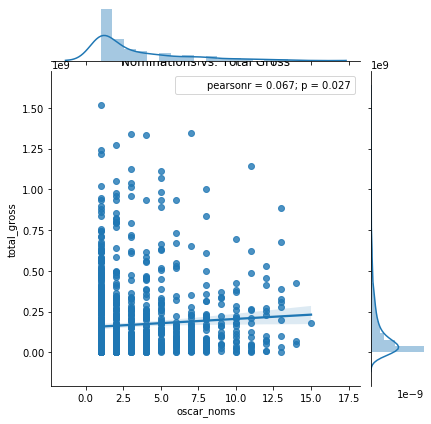

In [13]:
from scipy.stats import pearsonr

x ='oscar_noms'
y = 'total_gross'


# drop duplicates that exist because of genre unstacking (genre not relevant for this chart)
noms_vs_budget = oscar_df.loc[:,[x, y]].drop_duplicates().sort_values(y).dropna()[:-3] # exclude outliers
sns.jointplot(x,y, data = noms_vs_budget, stat_func=pearsonr, kind='reg');
plt.title('Nominations vs. Total Gross');


## Oscar Nominations and Total Gross Revenue, By Genre

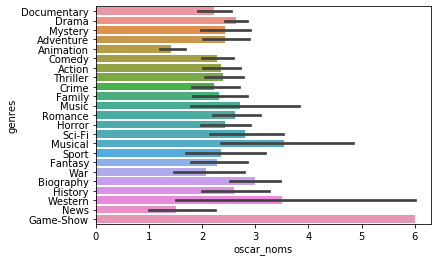

In [14]:
sns.barplot('oscar_noms','genres' , data = oscar_df);

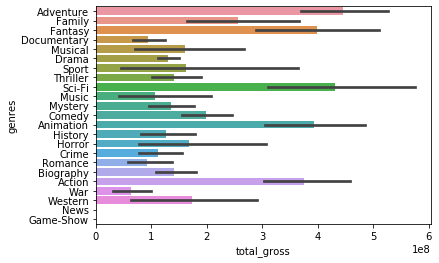

In [143]:
sns.barplot('total_gross','genres' , data = oscar_df);

# Question 2: How does Trailer Popularity impact Movie Success?
### Task: Compare movie trailer view counts to movie ratings and revenue

### Data of Interest:
- trailer views
- gross revenue
- online ratings

### Datasets:
https://grouplens.org/datasets/movielens/20m-youtube/

In [23]:
# slice year out of title string, merge with budgets table
trailers_raw = pd.read_csv('./zippedData/movie_trailers.zip')
trailers_raw['title'] = trailers_raw['title'].str[:-7]
trailers = trailers_raw.merge(budget_concat, on='title').sort_values('total_gross', ascending=False) #### remove this later
ids = list(trailers["youtubeId"].values[:])
trailers

,youtubeId,movieId,title,domestic_gross,foreign_gross,production_budget,total_gross,roi
2745,5MB3Ea6L-gw,72998,Avatar,760507625.0,2.776345e+09,425000000.0,3.536853e+09,732.20
459,yxIVO7P0iig,118916,Titanic,659363944.0,2.208208e+09,200000000.0,2.867572e+09,1333.79
458,dQ7MAigAhas,3404,Titanic,659363944.0,2.208208e+09,200000000.0,2.867572e+09,1333.79
457,2e-eXJ6HgkQ,1721,Titanic,659363944.0,2.208208e+09,200000000.0,2.867572e+09,1333.79
2799,TbQm5doF_Uc,106696,Frozen,400738009.0,1.272470e+09,150000000.0,1.673208e+09,1015.47
...,...,...,...,...,...,...,...,...
4012,myjar5KoqZA,129820,Spare Parts,3600000.0,NaN,NaN,NaN,NaN
4017,utmvmr7cgcg,130052,Clown,55000.0,NaN,NaN,NaN,NaN
4020,tRn3gr8Pt_o,130382,Mr. Pip,1700.0,NaN,NaN,NaN,NaN
4028,6uaWekLrilY,131023,That Sugar Film,3500.0,NaN,NaN,NaN,NaN


## Create function to feed in youtube id's of trailers and retrieve view counts

In [24]:

def getViews(youtubeIDs):
    views = []
    for i in youtubeIDs:
        try:
            url = "https://www.youtube.com/watch?v={}".format(i)
            html_page = requests.get(url) 
            soup = BeautifulSoup(html_page.text, 'html.parser')
            script = soup.find_all('script')[32]
            value = re.findall('ewCount":{"simpleText":"([\d,]+) views', str(soup))
            views.append(float(value[0].replace(',','')))
        except:
            views.append(0)
    return views


## Scrape all YouTube Trailers and save as CSV (Warning: takes ~1hr to run)
### Leave this commented out

In [25]:
# trailers['trailer_views'] = getViews(ids)
# trailers.to_csv('zippedData/trailerViews.csv')

# Final Trailer Views vs ROI DataFrame

In [26]:
# sort by trailer views and drop duplicates to keep only trailer with highest views
trailer_df = pd.read_csv('zippedData/trailerViews.csv')
trailer_df = trailer_df.loc[:,['title','youtubeId','production_budget', 'total_gross', 'roi', 'trailer_views']].sort_values('trailer_views', ascending=False)
trailer_df = trailer_df.drop_duplicates(subset= ['title'], keep='first').set_index('title')
trailer_df

,youtubeId,production_budget,total_gross,roi,trailer_views
title,,,,,
Unfaithful,j-V12tL78Mc,50000000.0,1.191145e+08,138.23,117290789.0
Ilo Ilo,ISovsVvX8Bg,NaN,1.156800e+06,NaN,67247941.0
Transformers: Dark of the Moon,3H8bnKdf654,195000000.0,1.123791e+09,476.30,53112332.0
The Fault in Our Stars,9ItBvH5J6ss,12000000.0,3.071668e+08,2459.72,44956623.0
Eden,pdbI0Fn4COQ,2300000.0,0.000000e+00,-100.00,43188495.0
...,...,...,...,...,...
Harry Brown,I2S3SraFmI0,7300000.0,1.202361e+07,64.71,0.0
Elles,YIWiNzszcAo,NaN,9.120000e+05,NaN,0.0
Miral,4t8E6_S9f4k,NaN,9.000000e+05,NaN,0.0


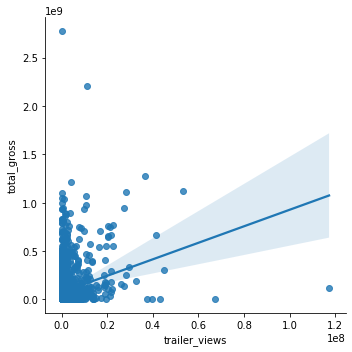

In [27]:
sns.lmplot('trailer_views', 'total_gross', data = trailer_df)

# Question 3: Do Music Scores Contribute to Movie Success?
### Task: Look at how music score ratings compare to movie ratings and ROI
### Data of Interest:
- Composers
- Music Score Rating
- Average Movie Rating
- TMDB rating
- IMDB rating
- ROI

### Datasets: 
- https://www.soundtrack.net/content/reviews/ (not sure if we will end up using this one)
- http://www.movie-wave.net/reviews-by-composer/


## Scrape music reviews page

In [28]:
page = requests.get("http://www.movie-wave.net/reviews-by-title/")
soup = BeautifulSoup(page.content, 'html.parser')
content =soup.find('div', class_="page-content")
p_list = content.findAll('p')

In [29]:
to_df =[]
for p in p_list:
    for a in p.findAll('a'):
        try:
           to_df.append([a.text, a.nextSibling, a.nextSibling.nextSibling.text])
        except:
            pass


## Create DataFrame with Music Ratings

In [30]:
music_df = pd.DataFrame(to_df, columns=['title', 'composer', 'stars'])
music_df['composer'] = music_df['composer'].str[:-7]

In [31]:
stars = list(music_df['stars'])
mapper = {'*****':5, '**** 1/2':4.5,'****':4,'*** 1/2':3.5,'***':3,'** 1/2':2.5,'**':2,'* 1/2':1.5,'*':1}
ratings = list(map(mapper.get, stars))
music_df['music_rating'] = ratings
music_df = music_df.drop('stars',axis=1)
music_df

,title,composer,music_rating
0,10 Cloverfield Lane,Bear McCreary,4.0
1,100 Rifles,Jerry Goldsmith,4.0
2,101 Dalmatians,Michael Kamen,4.5
3,102 Dalmatians,David Newman,4.0
4,"10,000BC",Harald Kloser and Thomas Wander,2.0
...,...,...,...
2294,Zathura,John Debney,4.0
2295,Zero Dark Thirty,Alexandre Desplat,4.0
2296,Zoolander 2,Theodore Shapiro,3.5
2297,Zootopia,Michael Giacchino,2.0


## Merge TMDB Ratings with Budget/ROI table


In [32]:
# Rename columns to specify TMDB, and subset data to only get columns of interest
tmdb = tmdb_raw.merge(budget_concat[['title', 'total_gross','production_budget', 'roi']], on='title', how='left')
tmdb.rename(columns ={'popularity':'tmdb_popularity', 'vote_average': 'tmdb_rating', 'vote_count': 'tmdb_votes'}, inplace=True)
tmdb = tmdb.loc[:,['title', 'tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi']]
tmdb.head()

,title,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,33.533,NaN,NaN,NaN
1,How to Train Your Dragon,7.7,7610,28.734,7.124522e+08,165000000.0,331.79
2,Iron Man 2,6.8,12368,28.515,9.335897e+08,170000000.0,449.17
3,Toy Story,7.9,10174,28.005,5.563417e+08,30000000.0,1754.47
4,Inception,8.3,22186,27.920,1.128101e+09,160000000.0,605.06


## merge in IMDB ratings with above TMDB table

In [33]:
# To retain as much info as possible, joined imdb_ratings with title table rather than title_basics
imdb = imdb_raw.merge(titles_raw,left_on ='tconst', right_on ='title_id')
imdb.rename(columns ={'averagerating':'imdb_rating', 'numvotes': 'imdb_votes'}, inplace=True)
imdb = imdb[['title', 'imdb_rating', 'imdb_votes' ]]
ratings = imdb.merge(tmdb, on='title', how='left')
ratings.head()

,title,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
1,Samo Ines,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
2,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
3,The Legend of Hercules,4.2,50352,4.5,805.0,13.754,77801857.0,70000000.0,11.15
4,Hércules - A Lenda Começa,4.2,50352,NaN,NaN,NaN,NaN,NaN,NaN


# Final Music X IMDB X TMDB X Revenue Table

In [34]:
final_music = music_df.merge(ratings, on='title', how='inner')


In [35]:
final_music

,title,composer,music_rating,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,1.803694e+08,5000000.0,3507.39
1,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,1.803694e+08,5000000.0,3507.39
2,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,1.803694e+08,5000000.0,3507.39
3,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,1.803694e+08,5000000.0,3507.39
4,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,1.803694e+08,5000000.0,3507.39
...,...,...,...,...,...,...,...,...,...,...,...
4487,Zootopia,Michael Giacchino,2.0,8.0,383446,7.7,9977.0,27.549,1.360698e+09,150000000.0,807.13
4488,Zootopia,Michael Giacchino,2.0,8.0,383446,7.7,9977.0,27.549,1.360698e+09,150000000.0,807.13
4489,Zootopia,Michael Giacchino,2.0,8.0,383446,7.7,9977.0,27.549,1.360698e+09,150000000.0,807.13
4490,Zootopia,Michael Giacchino,2.0,8.0,383446,7.7,9977.0,27.549,1.360698e+09,150000000.0,807.13


In [36]:
final_music.isnull().sum()

title                   0
composer                0
music_rating           84
imdb_rating             0
imdb_votes              0
tmdb_rating           558
tmdb_votes            558
tmdb_popularity       558
total_gross          1193
production_budget    1401
roi                  1401
dtype: int64


## Movie ROI's by Genre

In [37]:
gross = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

### Clean data and Computer ROI

In [38]:
gross['year'] = gross['release_date'].str[-4:].astype(float)
gross['domestic_gross'] = gross['domestic_gross'].str.replace(',', '')
gross['domestic_gross'] = gross['domestic_gross'].str.replace('$', '').astype(float)
gross['production_budget'] = gross['production_budget'].str.replace(',', '')
gross['production_budget'] = gross['production_budget'].str.replace('$', '').astype(float)
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace(',', '')
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace('$', '').astype(float)

In [39]:
gross['ROI'] = (((gross['worldwide_gross'] - gross['production_budget']) / gross['production_budget'] ) * 100)

In [40]:
gross.rename(columns = {'movie': 'original_title'}, inplace=True)

In [41]:
gross.set_index('original_title')

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,ROI
original_title,,,,,,,
Avatar,1,"Dec 18, 2009",425000000.0,760507625.0,2.776345e+09,2009.0,553.257713
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000.0,241063875.0,1.045664e+09,2011.0,154.667286
Dark Phoenix,3,"Jun 7, 2019",350000000.0,42762350.0,1.497624e+08,2019.0,-57.210757
Avengers: Age of Ultron,4,"May 1, 2015",330600000.0,459005868.0,1.403014e+09,2015.0,324.384139
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000.0,620181382.0,1.316722e+09,2017.0,315.369636
...,...,...,...,...,...,...,...
Red 11,78,"Dec 31, 2018",7000.0,0.0,0.000000e+00,2018.0,-100.000000
Following,79,"Apr 2, 1999",6000.0,48482.0,2.404950e+05,1999.0,3908.250000
Return to the Land of Wonders,80,"Jul 13, 2005",5000.0,1338.0,1.338000e+03,2005.0,-73.240000


### Stack Genre DataFrame and Merge with Financial Data

In [42]:
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
genre_raw

genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('original_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['original_title', 'genres']

In [43]:
genre_roi = genre_unstack.merge(gross[['original_title', 'ROI']], on='original_title', how='left')

In [44]:
genre_roi.dropna(axis = 0, inplace = True)

### Bar Chart Displaying Musicals Having Highest Average ROI

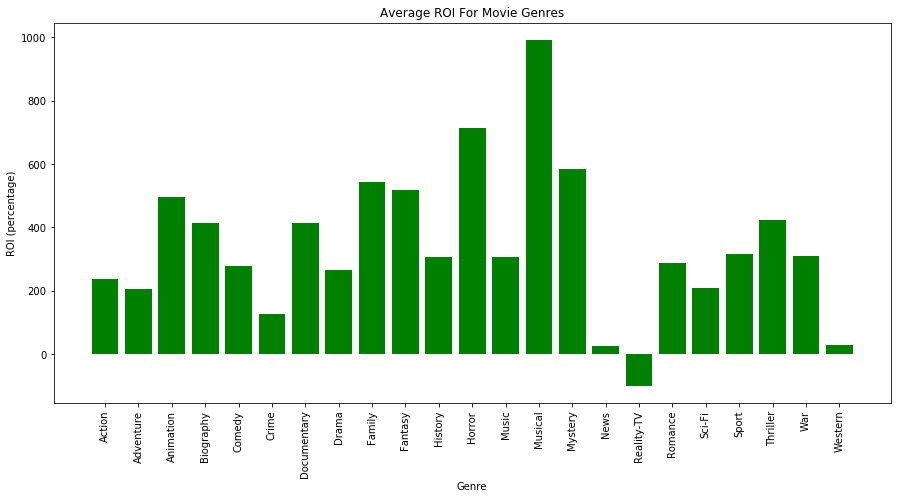

In [45]:
y = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

figure, ax = plt.subplots(figsize = (15,7))

ax.set_title('Average ROI For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

##### Musicals have the highest ROI ----- notes -------- look for what composers are for what musicals

## Compiling for Composer Dataframe

### Stack Column Listing Movie IDs for Each Crew Member

In [46]:
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
crew_raw

crew = crew_raw
crew['directors'] = crew['directors'].str.split(',', 5)
crew_unstack = crew.set_index('tconst').directors.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
crew_unstack.columns = ['tconst', 'id']

### Stack Column Listing Roles a Crew Member Held in Production

In [47]:
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
name_basics_raw.rename(columns = {'nconst' : 'directors', 'title_id':'tconst'}, inplace=True)
name_basics_raw

name_basics = name_basics_raw
name_basics['primary_profession'] = name_basics['primary_profession'].str.split(',', 5)
name_basics_unstack = name_basics.set_index('directors').primary_profession.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()

In [48]:
name_basics_unstack.columns = ['id', 'job_title']

In [49]:
name_basics.rename(columns={'directors':'id'}, inplace=True)

#### Pulling in Data and Matching indices to Merge

In [50]:
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
titles_raw.rename(columns = {'title_id':'tconst', 'title' : 'original_title'}, inplace=True)

In [51]:
roi_with_title = genre_roi.merge(titles_raw[['original_title', 'tconst']], on='original_title', how='inner')
roi_with_title.drop_duplicates(inplace=True)

In [52]:
composer = name_basics_unstack[name_basics_unstack['job_title'] == 'composer']

In [53]:
composers = crew_unstack.merge(composer[['id', 'job_title']], on='id', how='left')
composers.dropna(inplace=True)
composers.set_index('id', inplace=True)

In [54]:
composers_names = composer.merge(name_basics[['id', 'primary_name']], on='id', how='left')

In [55]:
composers_names.set_index('primary_name')

,id,job_title
primary_name,,
Joseph Bauer,nm0061865,composer
Stevie Be-Zet,nm0063432,composer
Jeff Beal,nm0063618,composer
Gavin Bellour,nm0069225,composer
Jorge Ben Jor,nm0069990,composer
...,...,...
Oscar Martorell,nm9786484,composer
Shine Issai,nm9927305,composer
Ifthi,nm9942831,composer


In [56]:
crew = crew_unstack.merge(name_basics_raw[['id', 'primary_name']], on='id', how='left')

In [57]:
roi_crew_genre = roi_with_title.merge(crew[['tconst', 'primary_name']], on='tconst', how='left')
roi_crew_genre.drop_duplicates(inplace=True)
roi_crew_genre.set_index('primary_name')

,original_title,genres,ROI,tconst
primary_name,,,,
Lawrence Kasanoff,Foodfight!,Action,-99.836209,tt0249516
Lawrence Kasanoff,Foodfight!,Animation,-99.836209,tt0249516
Lawrence Kasanoff,Foodfight!,Comedy,-99.836209,tt0249516
Simon McQuoid,Mortal Kombat,Action,510.666135,tt0293429
Simon McQuoid,Mortal Kombat,Adventure,510.666135,tt0293429
...,...,...,...,...
Gijsbert Tukker,Darkness,Sci-Fi,224.615151,tt4341750
Jug Radivojevic,Darkness,Sci-Fi,224.615151,tt3961040
Susanna White,Traitor,Action,26.737391,tt1995390


In [58]:
composer_ = roi_crew_genre.merge(composers_names[['job_title', 'primary_name']], on='primary_name', how='inner')

In [59]:
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')

In [60]:
composer_df = composer_.merge(imdb_raw[['tconst', 'averagerating']], on='tconst', how='left')
composer_df.rename(columns={'primary_name': 'composer'}, inplace=True)
composer_df.set_index('composer', inplace=True)

In [61]:
music_df.set_index('composer', inplace=True)

In [62]:
### can look at how the music rating varies from the overall movie rating

In [63]:
ratings.head()

,title,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
1,Samo Ines,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
2,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
3,The Legend of Hercules,4.2,50352,4.5,805.0,13.754,77801857.0,70000000.0,11.15
4,Hércules - A Lenda Começa,4.2,50352,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
music_df.head()

,title,music_rating
composer,,
Bear McCreary,10 Cloverfield Lane,4.0
Jerry Goldsmith,100 Rifles,4.0
Michael Kamen,101 Dalmatians,4.5
David Newman,102 Dalmatians,4.0
Harald Kloser and Thomas Wander,"10,000BC",2.0


In [65]:
music_movie_ratings = music_df.merge(composer_df[['averagerating']], on='composer', how='left')

In [66]:
music_movie_ratings

,title,music_rating,averagerating
composer,,,
Bear McCreary,10 Cloverfield Lane,4.0,NaN
Jerry Goldsmith,100 Rifles,4.0,NaN
Michael Kamen,101 Dalmatians,4.5,NaN
David Newman,102 Dalmatians,4.0,NaN
Harald Kloser and Thomas Wander,"10,000BC",2.0,NaN
...,...,...,...
John Debney,Zathura,4.0,NaN
Alexandre Desplat,Zero Dark Thirty,4.0,NaN
Theodore Shapiro,Zoolander 2,3.5,NaN


In [67]:
music_movie_ratings.isnull().sum()

title               0
music_rating       29
averagerating    2299
dtype: int64

In [68]:
### There is no overlap ughhhhhhhhhhhhfusbcisnicsifnc

In [69]:
composer_df

,original_title,genres,ROI,tconst,job_title,averagerating
composer,,,,,,
Robert Rodriguez,Alita: Battle Angel,Action,137.044727,tt0437086,composer,7.5
Robert Rodriguez,Alita: Battle Angel,Adventure,137.044727,tt0437086,composer,7.5
Robert Rodriguez,Alita: Battle Angel,Sci-Fi,137.044727,tt0437086,composer,7.5
Robert Rodriguez,Sin City: A Dame to Kill For,Crime,-37.460243,tt0458481,composer,6.5
Robert Rodriguez,Sin City: A Dame to Kill For,Thriller,-37.460243,tt0458481,composer,6.5
...,...,...,...,...,...,...
Antonis Sotiropoulos,The Bachelor,Romance,75.630371,tt5748648,composer,5.1
David Sudmalis,The House of Mirth,Music,-48.508690,tt5867616,composer,NaN
Geremy Jasper,Patti Cake$,Drama,47.109000,tt6288250,composer,6.7


In [70]:
composer_df.ROI.mean()

940.8412287072595

In [71]:
composer_df.ROI.std()

2388.71566102759

In [72]:
ratings.roi.mean()

704.7362720165772

In [73]:
ratings.roi.std()

2272.2474122123313

##### composer dataframe has higher mean but also higher std




In [74]:
### did a movie with a composer do better than the overall average ratings?

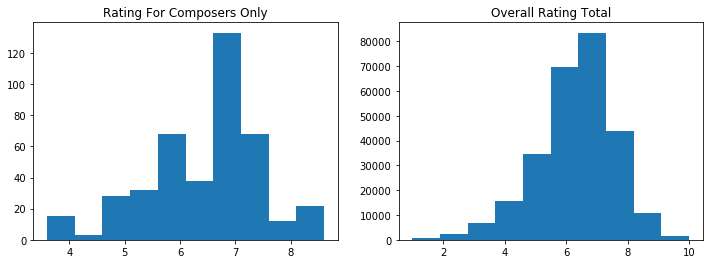

In [75]:
figure, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_title('Rating For Composers Only')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

y = composer_df.averagerating

ax[0].hist(y);

ax[1].set_title('Overall Rating Total')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

y = ratings.imdb_rating

ax[1].hist(y);

In [76]:
#### we should get the mean and standard dev
composer_df['averagerating'].mean()

6.389737470167065

In [77]:
ratings['imdb_rating'].mean()

6.2688522154496455

In [78]:
composer_df['averagerating'].std()

1.0393523368884579

In [79]:
ratings['imdb_rating'].std()

1.2575963534615557

### INSIGHTS -------
#### mean is slightly higher and std dev is lower for the composers than overall

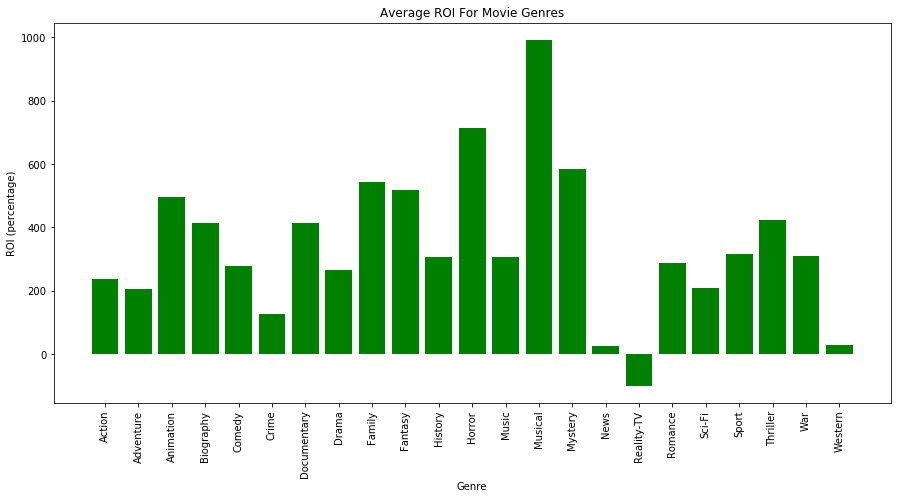

In [80]:
y = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

figure, ax = plt.subplots(figsize = (15,7))

ax.set_title('Average ROI For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

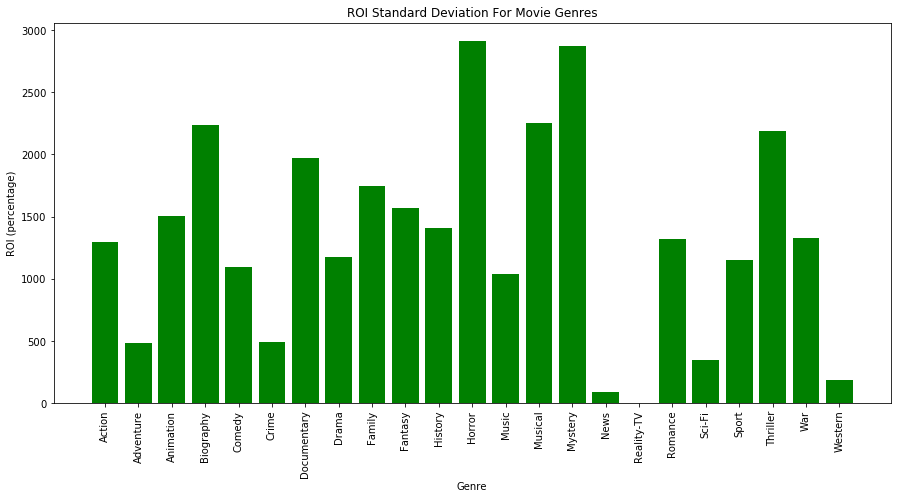

In [81]:
y = genre_roi.groupby(['genres'])['ROI'].std()
x = y.index

figure, ax = plt.subplots(figsize = (15,7))

ax.set_title('ROI Standard Deviation For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

In [82]:
genre_roi[genre_roi['genres'] == 'Musical']['ROI'].mean()

991.4542870400787

In [83]:
genre_roi[genre_roi['genres'] == 'Musical']['ROI'].std()

2253.3132639579585

In [84]:
genre_roi[genre_roi['genres'] == 'Horror']['ROI'].mean()

712.2093886541527

In [85]:
genre_roi[genre_roi['genres'] == 'Horror']['ROI'].std()

2915.2651634191407

In [86]:
genre_roi[genre_roi['genres'] == 'Mystery']['ROI'].mean()

584.2238090720975

In [87]:
genre_roi[genre_roi['genres'] == 'Mystery']['ROI'].std()

2870.320189526222

## The top three Average ROIs have the highest standard dev

In [88]:
### could look into how much better the remake did  for musicals -- wait only 6 remakes though